In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline 
plt.style.use('ggplot')

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [123]:
df = pd.read_csv('cag.us.txt')

In [124]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8362.000000,8362.000000,8362.000000,8362.000000,8.362000e+03,8362.0
mean,17.008013,17.160866,16.847998,17.012783,2.351712e+06,0.0
std,10.135231,10.208821,10.063380,10.139211,2.208917e+06,0.0
min,1.446300,1.446300,1.421500,1.446300,0.000000e+00,0.0
25%,8.586500,8.668300,8.512600,8.594700,8.612980e+05,0.0
50%,17.831000,17.995000,17.636500,17.831000,1.664544e+06,0.0
75%,21.529250,21.693000,21.356000,21.536750,3.229892e+06,0.0
max,47.079000,47.764000,46.910000,47.589000,3.598559e+07,0.0


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8362 entries, 0 to 8361
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     8362 non-null   object 
 1   Open     8362 non-null   float64
 2   High     8362 non-null   float64
 3   Low      8362 non-null   float64
 4   Close    8362 non-null   float64
 5   Volume   8362 non-null   int64  
 6   OpenInt  8362 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 457.4+ KB


In [126]:
# transform the data to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [127]:
df.set_axis(df['Date'], inplace=True)
df.drop(['Open', 'High', 'Low', 'Volume', 'OpenInt'], axis=1, inplace=True)

In [128]:
df

,Date,Close
Date,,
1984-09-07,1984-09-07,1.5039
1984-09-10,1984-09-10,1.4955
1984-09-11,1984-09-11,1.5283
1984-09-12,1984-09-12,1.5283
1984-09-13,1984-09-13,1.5118
...,...,...
2017-11-06,2017-11-06,33.3200
2017-11-07,2017-11-07,33.7600
2017-11-08,2017-11-08,34.3100


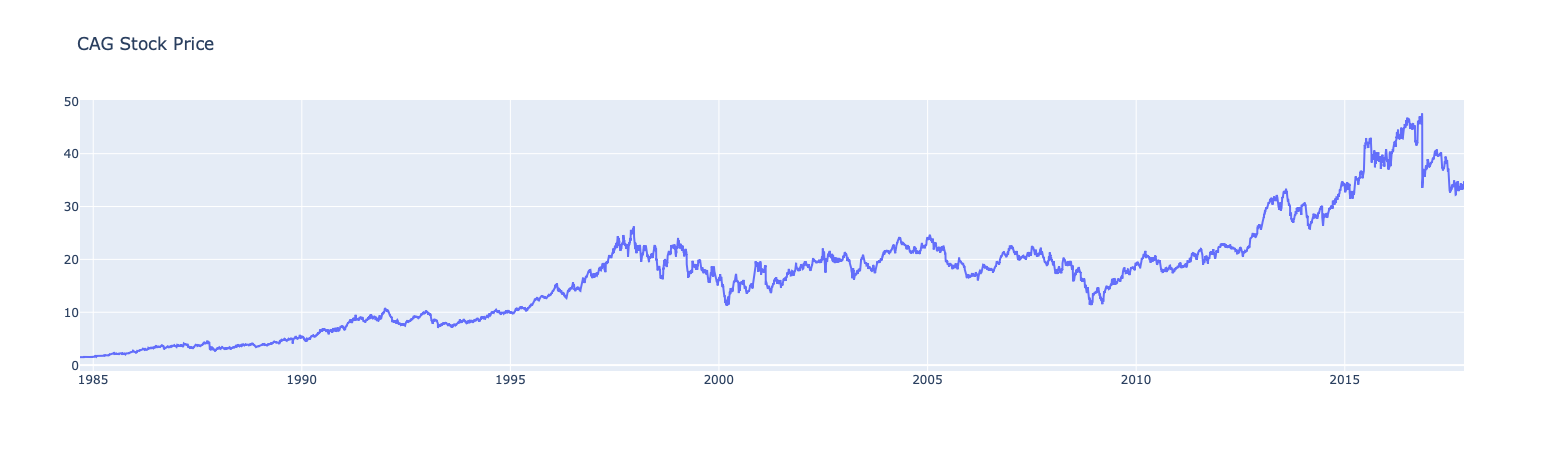

In [129]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=df['Close'], x=df['Date'],  name='Trend'))
fig.update_layout(title = 'CAG Stock Price')
fig.show()

## Prepare the Data for Modeling

In [130]:
# split data to train and test 0.9
close_data = df['Close'].values.reshape(-1,1)

In [131]:
split_percent=0.9
split = int(split_percent * len(close_data))
train_close = close_data[:split]
test_close = close_data[split:]

In [132]:
train_date = df['Date'][:split]
test_date = df['Date'][split:]

In [133]:
print(train_close.size, test_close.size)

7525 837


In [134]:
# Transform train and test datasets to supervised learning dataframe as features and target using Keras TimeseriesGenerator
# use a sampling rate as one (by default) as we don't want to skip any samples in the datasets.

## use 50 lags
look_back = 50

train_generator = TimeseriesGenerator(train_close, train_close, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(test_close, test_close, length=look_back, batch_size=1)

In [135]:
# take a look at the train_generator
X, y = train_generator[0]

In [136]:
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

W1016 13:03:26.475109 4621540800 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 374 steps
Epoch 1/25
374/374 [==============================] - 6s 15ms/step - loss: 2.7405
Epoch 2/25
374/374 [==============================] - 5s 13ms/step - loss: 0.2248
Epoch 3/25
374/374 [==============================] - 5s 13ms/step - loss: 0.1054
Epoch 4/25
374/374 [==============================] - 5s 13ms/step - loss: 0.0950
Epoch 5/25
374/374 [==============================] - 5s 13ms/step - loss: 0.0829
Epoch 6/25
374/374 [==============================] - 5s 13ms/step - loss: 0.0798
Epoch 7/25
374/374 [==============================] - 5s 13ms/step - loss: 0.0816
Epoch 8/25
374/374 [==============================] - 4s 12ms/step - loss: 0.0777
Epoch 9/25
374/374 [==============================] - 5s 14ms/step - loss: 0.0743
Epoch 10/25
374/374 [==============================] - 8s 20ms/step - loss: 0.0704
Epoch 11/25
374/374 [==============================] - 7s 20ms/step - loss: 0.0717
Epoch 12/25
374/374 [==============================] - 6s 15ms/step - loss: 

In [137]:
model.evaluate(test_generator)
trainPredict = model.predict(train_generator)
testPredict = model.predict(test_generator)

W1016 13:05:54.185347 4621540800 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


787/787 [==============================] - 4s 5ms/step - loss: 0.7575


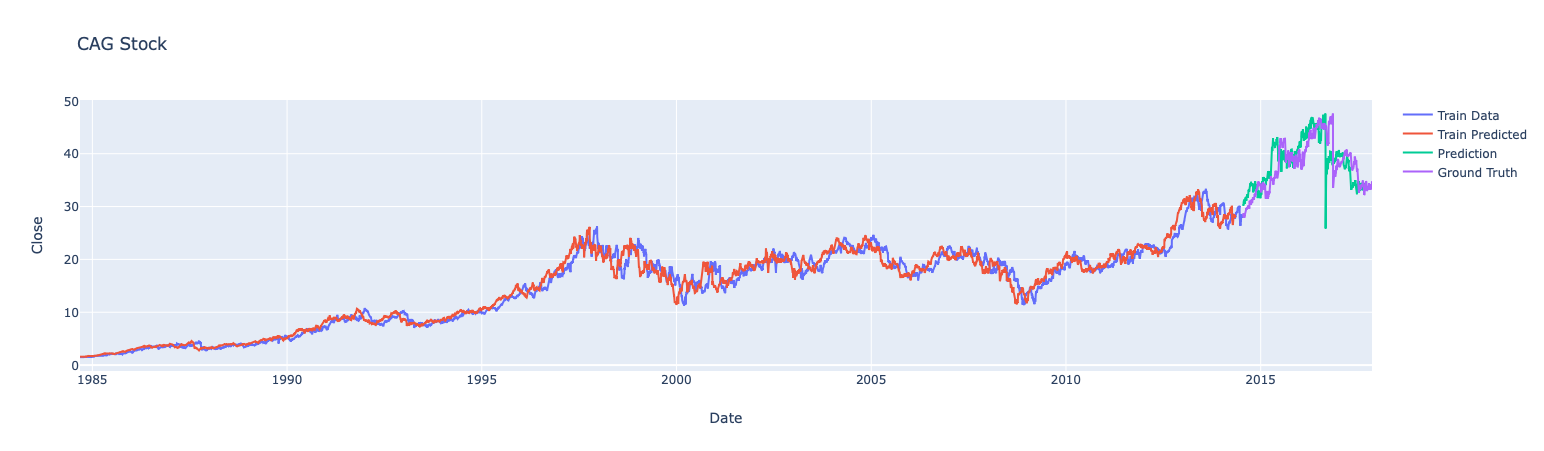

In [138]:
fig = go.Figure()
# fig.add_trace(go.Scatter(y=df['Close'], x=df['Date'],  name='Real'))
# fig.add_trace(go.Scatter(y=trainPredict, x=df['Date'], name='Predicted'))
# fig.update_layout(title = 'CAG Stock Price')
# fig.show()

train_close = train_close.reshape((-1))
test_close = test_close.reshape((-1))
train_predicted = trainPredict.reshape((-1))
test_predicted = testPredict.reshape((-1))

trace1 = go.Scatter(
    x = train_date,
    y = train_close,
    mode = 'lines',
    name = 'Train Data'
)
trace2 = go.Scatter(
    x=train_date,
    y=train_predicted,
    mode='lines',
    name='Train Predicted'

)
trace3 = go.Scatter(
    x = test_date,
    y = test_predicted,
    mode = 'lines',
    name = 'Prediction'
)
trace4 = go.Scatter(
    x = test_date,
    y = test_close,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "CAG Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

In [139]:
## Predict the next one month price

close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [140]:
forecast

array([34.8       , 34.92038345, 34.83493805, 34.70284653, 34.58660889,
       34.48452759, 34.39230728, 34.30758667, 34.22729111, 34.14928436,
       34.07217026, 33.99501038, 33.91945267, 33.8461113 , 33.77537537,
       33.70798874, 33.64346695, 33.58086777, 33.52016449, 33.46128464,
       33.40362167, 33.34695816, 33.29091644, 33.23498917, 33.17922211,
       33.12419128, 33.06984329, 33.01596832, 32.96168137, 32.90600586,
       32.84846497])

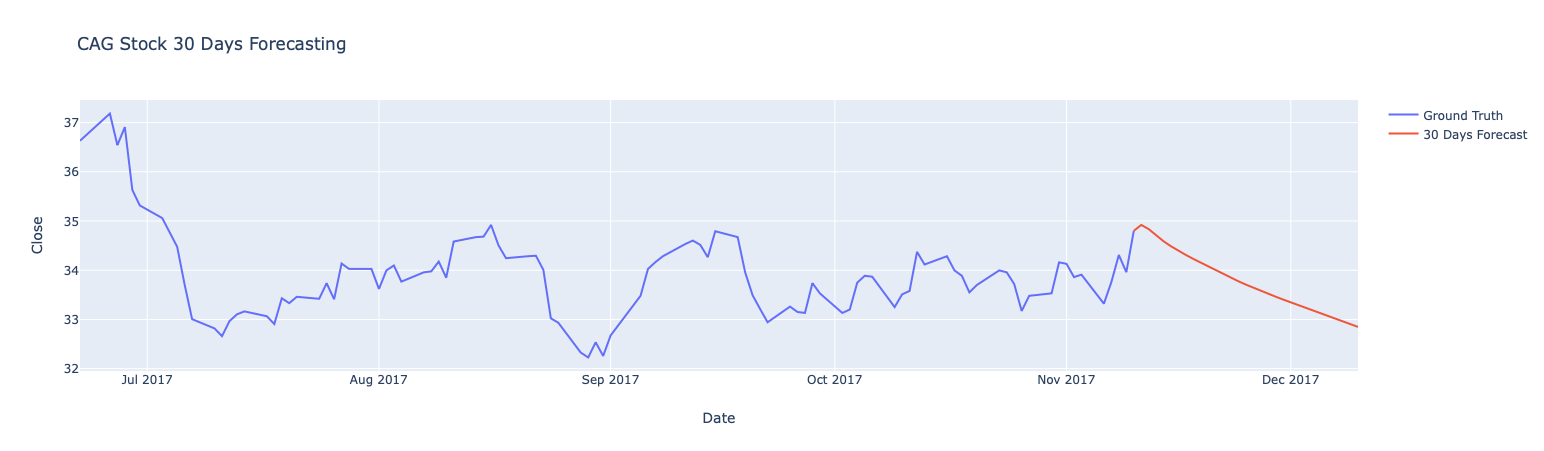

In [143]:
fig = go.Figure()
# fig.add_trace(go.Scatter(y=df['Close'], x=df['Date'],  name='Real'))
# fig.add_trace(go.Scatter(y=trainPredict, x=df['Date'], name='Predicted'))
# fig.update_layout(title = 'CAG Stock Price')
# fig.show()


test_close = test_close.reshape((-1))
test_predicted = testPredict.reshape((-1))
forecast = forecast.reshape((-1))

trace1 = go.Scatter(
    x = test_date[-100:],
    y = test_close[-100:],
    mode='lines',
    name = 'Ground Truth'
)

trace2 = go.Scatter(
    x=forecast_dates,
    y=forecast,
    mode='lines',
    name='30 Days Forecast'
)
layout = go.Layout(
    title = "CAG Stock 30 Days Forecasting",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

